# Классификация - и снова в бой!

Сегодня мы поговорим о том, чему же мы научились за последние практики?

Мы освоили основным методы работы как с данными, на основе которых можно решить задачу классификации, так и с моделями, которые это делают! Щикарррно!

Сегодняшняя задачка как всегда несложная, но очень важная - нам предстоит предсказывать болезни сердца!

В вашем распоряжении датасет [Heart Disease UCI](https://www.kaggle.com/ronitf/heart-disease-uci). Ваша задача предсказать, есть ли у человека заболевание сердца или нет.

Как всегда, ждем от вас полноценного анализа исходных данных, подготовка необходимой предобработки, feature engineering и поиск лучшего варианта, которный даст наибольшую метрику!

* Задача под звездочкой. Попробуйте реализовать такую систему, которая реже пропускает больных пациентов - мы ведь не хотим больным людям говорить, что они здоровы, хотя это не так?

Мы желаем вам удачи - постарайтесь применить все накопленные знания и, может, чуть больше! Успехов!

In [5]:
# Зафиксируем состояние случайных чисел
import random
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt


RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

In [79]:
df_src = pd.read_csv('heart_cleveland_upload.csv')
df_src

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
0,69,1,0,160,234,1,2,131,0,0.1,1,1,0,0
1,69,0,0,140,239,0,0,151,0,1.8,0,2,0,0
2,66,0,0,150,226,0,0,114,0,2.6,2,0,0,0
3,65,1,0,138,282,1,2,174,0,1.4,1,1,0,1
4,64,1,0,110,211,0,2,144,1,1.8,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,40,1,3,152,223,0,0,181,0,0.0,0,0,2,1
293,39,1,3,118,219,0,0,140,0,1.2,1,0,2,1
294,35,1,3,120,198,0,0,130,1,1.6,1,0,2,1
295,35,0,3,138,183,0,0,182,0,1.4,0,0,0,0


In [80]:
df_src.isnull().sum()

age          0
sex          0
cp           0
trestbps     0
chol         0
fbs          0
restecg      0
thalach      0
exang        0
oldpeak      0
slope        0
ca           0
thal         0
condition    0
dtype: int64

In [82]:
df_src['condition'].value_counts()

0    160
1    137
Name: condition, dtype: int64

In [69]:
from sklearn.model_selection import train_test_split


train_data, test_data = train_test_split(
    df_src,
    test_size=0.3,
    stratify=df_src['condition'],
    shuffle=True,
    random_state=RANDOM_SEED
)

In [ ]:
from sklearn.linear_model import LogisticRegression


model = LogisticRegression(random_state=RANDOM_SEED)
train_y = train_data.pop('condition')
model.fit(train_data, train_y)
test_y = test_data.pop('condition')
pred_y = model.predict(test_data)

In [71]:
from sklearn.metrics import accuracy_score


accuracy = accuracy_score(test_y, pred_y)
print(f"Accuracy: {accuracy}")

Accuracy: 0.7472527472527473


In [72]:
from sklearn.metrics import (
    recall_score,
    precision_score,
    f1_score
)


def cm(test_y, pred_y):
    rec = recall_score(
        test_y,
        pred_y,
        average='binary',
        pos_label=1
    )
    prec = precision_score(test_y, pred_y)
    f1 = f1_score(test_y, pred_y)
    accuracy = accuracy_score(test_y, pred_y)
    result = {
        'recall': rec,
        'precision': prec,
        'f1': f1,
        'accuracy': accuracy
    }
    return result

In [73]:
metrics = cm(test_y, pred_y)
metrics

{'recall': 0.8,
 'precision': 0.7547169811320755,
 'f1': 0.7766990291262137,
 'accuracy': 0.7472527472527473}

In [74]:
#Опираемся на recall, т.к. необходимо не допустить ошибки при определении диагноза и не присвоить его здоровому человеку
def predict_threshold(prob_y, threshold):
    res = []
    for item in prob_y[:,1]:
        if item >= threshold:
            res.append(1)
            continue
        res.append(0)
    return res

In [75]:
prob_y = model.predict_proba(test_data)

In [76]:
pred_y_new = predict_threshold(prob_y, 0.2)
test_metrics = cm(test_y, pred_y_new)
test_metrics

{'recall': 0.94,
 'precision': 0.7704918032786885,
 'f1': 0.8468468468468469,
 'accuracy': 0.8131868131868132}

In [77]:
from sklearn import metrics
from sklearn.metrics import precision_recall_curve


precision, recall, thresholds = precision_recall_curve(test_y, prob_y[:,1])
auc = metrics.auc(recall, precision)
auc

0.8821269243223866

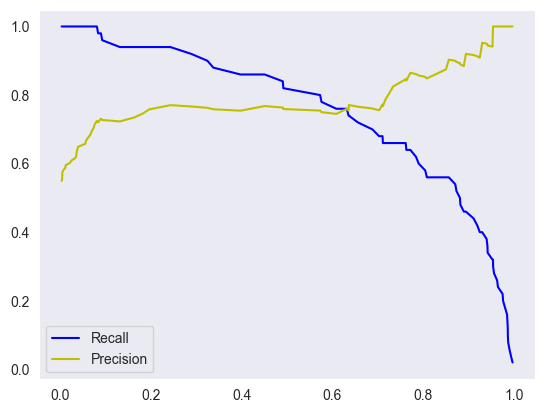

In [78]:
plt.plot(
    thresholds,
    recall[0:-1],
    'b',
    label='Recall'
)
plt.plot(
    thresholds,
    precision[0:-1],
    'y',
    label='Precision'
)
plt.grid()
plt.legend()
plt.show()

In [55]:
precision, recall, threshold = metrics.roc_curve(test_y, prob_y[:,1])
auc = metrics.auc(precision, recall)
auc

0.9221230158730158

Вывод:

Исходя из графика можно сказать, что точка пересечения кривых является оптимальным порогом. В качестве порога выбрана точка 0.2, т.к. в диапазоне [0.2 0.6] **precision** почти прямолинейный, а **recall** - стремительно снижается, поэтому выбрали 0.2, где **recall** - **max**.
В данной точке **precision** = 0.77, **recall** - еще не снижается.

В результате получены следующие метрики:

**recall** = 0.94
**precision** = 0.7704918032786885
**f1** = 0.8468468468468469
**accuracy** = 0.8131868131868132
